In [1]:
import pandas as pd
import numpy as np
import time
import joblib
import json
import collections
import xlrd
from sklearn import preprocessing
from tensorflow.keras.models import model_from_json
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import encoding_data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 100

In [2]:
with open('raw_data/configure.json', 'r') as f:
    metadata = json.load(f)

In [3]:
print(len(metadata['input_drop']))
print(len(metadata['input_int']))
print(len(metadata['input_bool']))

23
75
40


In [4]:
75+3+40+8

126

## Read the human agent evaluation results!

In [5]:
df_agent = pd.read_excel('evaluation/ipynb_use.xlsx')

In [6]:
df_agent.head()

,TenantId,CountryCode,TopParents_Industry,AllupSeats,PaidCount,exchange_usage,sharepoint_usage,skype_usage,teams_usage,od4b_usage,onenote_usage,word_usage,excel_usage,powerpoint_usage,outlook_usage,eslt_usage,officeclient_usage,Valid_Choice,Rec_model,Agent_choice
0,61BEFEAC-AAD0-4D27-80DB-BEA99BAA3276,BE,Consumer Goods,99,99,0.756122,0.000000,0.002551,0.000510,0.117677,0.134848,0.304545,0.335354,0.211111,0.566667,0.753535,0.593434,"['od4b', 'sharepoint', 'exchange', 'teams', 'eslt', 'skype']","['sharepoint', 'teams', 'skype']","['sharepoint', 'powerpoint']"
1,96847494-5BF3-483A-954E-0205FCC59791,IL,Other - Unsegmented,190,188,0.786188,0.041477,0.000000,0.026571,0.023352,0.005851,0.175266,0.160638,0.040691,0.335372,0.761170,0.353457,"['od4b', 'sharepoint', 'exchange', 'teams', 'eslt', 'skype']","['eslt', 'od4b', 'exchange', 'sharepoint', 'teams', 'skype']",['teams']
2,C80F14D1-98F4-4E83-94E7-376CC5B34D63,US,Discrete Manufacturing,12,12,0.316667,0.000000,0.000000,0.000000,0.012500,0.000000,0.120833,0.108333,0.000000,0.325000,0.316667,0.341667,"['od4b', 'sharepoint', 'exchange', 'teams', 'eslt', 'skype']","['od4b', 'sharepoint', 'teams']",['officeclient']
3,FBDE669A-8B4E-4E6C-A078-C1A71E185C52,IT,Chemicals & Agrochemicals,160,50,0.000000,0.300000,0.000000,0.000000,0.042000,0.000000,0.394000,0.544000,0.084000,0.578000,0.071000,0.608000,"['od4b', 'sharepoint', 'exchange', 'teams', 'eslt', 'skype']","['exchange', 'eslt', 'teams']",['teams']
4,93F7AC5D-F331-4033-98D9-AFE7CBB6CE43,CA,Travel & Transportation,69,68,0.847674,0.027273,0.000000,0.012500,0.015909,0.030147,0.108824,0.108824,0.002206,0.158824,0.541176,0.163235,"['od4b', 'sharepoint', 'exchange', 'teams', 'eslt', 'skype']","['eslt', 'exchange', 'teams']","['teams', 'exchange']"


In [7]:
df_agent.columns = ['TenantId',
 'CountryCode',
 'TopParents_Industry',
 'AllupSeats',
 'PaidCount',
 'exchange_usage',
 'sharepoint_usage',
 'skype_usage',
 'teams_usage',
 'od4b_usage',
 'onenote_usage',
 'word_usage',
 'excel_usage',
 'powerpoint_usage',
 'outlook_usage',
 'eslt_usage',
 'officeclient_usage',
 'Valid_Choice',
 'Rec_model',
 'Agent_choice']

In [8]:
df_agent.iloc[345:347, -1]

345    ['skype']
346         ['']
Name: Agent_choice, dtype: object

In [9]:
df_agent = df_agent.drop(index=346)

In [10]:
# df_fake = df_agent.iloc[:10, :].copy()
# # df_fake.iloc[0,-3]
# # convert the string to a list of workloads for the last 3 columns
def string_to_list(string):
    result = string[1:-1]
    result = result.replace("'", "")
    result = result.split(', ')
    return result

In [11]:
def count_agent_pick(df):
    agent_valid_pick = []
    model_match = []
    agent_pick_multiple = []
    model_pick_count = []
    
    
    for i, row in df.iterrows():
        agent_pick_str = row['Agent_choice']
        agent_pick_list = string_to_list(agent_pick_str)
#         print(agent_pick_list)

        model_pick_str = row.Rec_model
        model_pick_list = string_to_list(model_pick_str)
        model_pick_count.append(len(model_pick_list))

        valid_str = row.Valid_Choice
        valid_list = string_to_list(valid_str)
        
        if len(agent_pick_list) == 1:
            agent_pick_multiple.append(0)
            if agent_pick_list[0] in valid_list:
                agent_valid_pick.append(1)
                if agent_pick_list[0] in model_pick_list:
                    model_match.append(1)
                else: 
                    model_match.append(0)
            else:
                agent_valid_pick.append(0)
                model_match.append(1)
        
        else:
            agent_pick_multiple.append(1)
            agent_valid_pick_cach = np.zeros((len(agent_pick_list)))
            model_match_cach = np.zeros((len(agent_pick_list)))
            
            for j, wl in enumerate(agent_pick_list):
                if wl in valid_list:
                    agent_valid_pick_cach[j] = 1
                    if wl in model_pick_list:
                        model_match_cach[j] = 1
                    else: 
                        model_match_cach[j] = 0  
                else:
                    agent_valid_pick_cach[j] = 0
                    model_match_cach[j] = 1
            
            if np.sum(agent_valid_pick_cach) == 0:
                agent_valid_pick.append(0)
            else:
                agent_valid_pick.append(1)
            
            if np.sum(model_match_cach) == 0:
                model_match.append(0)
            else:
                model_match.append(1)
#     print(len(agent_valid_pick))  
#     print(len(model_match))
#     print(len(agent_pick_multiple))
    df['Agent_valid_pick'] = agent_valid_pick
    df['model_match'] = model_match
    df['agent_pick_multiple'] = agent_pick_multiple
    df['model_pick_count'] = model_pick_count
        
    return df



In [12]:
# df_fake = count_agent_pick(df_fake)
# df_fake

In [13]:
df_agent = count_agent_pick(df_agent)
df_agent_valid = df_agent.loc[df_agent.Agent_valid_pick == 1]
print('total valid agent choice: {}'.format(df_agent_valid.shape[0]))
print('the number of rec from model: {}'.format(sum(df_agent_valid.model_pick_count) / df_agent_valid.shape[0]))

total valid agent choice: 472
the number of rec from model: 3.608050847457627


In [14]:
df_agent_valid.head()

,TenantId,CountryCode,TopParents_Industry,AllupSeats,PaidCount,exchange_usage,sharepoint_usage,skype_usage,teams_usage,od4b_usage,onenote_usage,word_usage,excel_usage,powerpoint_usage,outlook_usage,eslt_usage,officeclient_usage,Valid_Choice,Rec_model,Agent_choice,Agent_valid_pick,model_match,agent_pick_multiple,model_pick_count
0,61BEFEAC-AAD0-4D27-80DB-BEA99BAA3276,BE,Consumer Goods,99,99,0.756122,0.000000,0.002551,0.000510,0.117677,0.134848,0.304545,0.335354,0.211111,0.566667,0.753535,0.593434,"['od4b', 'sharepoint', 'exchange', 'teams', 'eslt', 'skype']","['sharepoint', 'teams', 'skype']","['sharepoint', 'powerpoint']",1,1,1,3
1,96847494-5BF3-483A-954E-0205FCC59791,IL,Other - Unsegmented,190,188,0.786188,0.041477,0.000000,0.026571,0.023352,0.005851,0.175266,0.160638,0.040691,0.335372,0.761170,0.353457,"['od4b', 'sharepoint', 'exchange', 'teams', 'eslt', 'skype']","['eslt', 'od4b', 'exchange', 'sharepoint', 'teams', 'skype']",['teams'],1,1,0,6
3,FBDE669A-8B4E-4E6C-A078-C1A71E185C52,IT,Chemicals & Agrochemicals,160,50,0.000000,0.300000,0.000000,0.000000,0.042000,0.000000,0.394000,0.544000,0.084000,0.578000,0.071000,0.608000,"['od4b', 'sharepoint', 'exchange', 'teams', 'eslt', 'skype']","['exchange', 'eslt', 'teams']",['teams'],1,1,0,3
4,93F7AC5D-F331-4033-98D9-AFE7CBB6CE43,CA,Travel & Transportation,69,68,0.847674,0.027273,0.000000,0.012500,0.015909,0.030147,0.108824,0.108824,0.002206,0.158824,0.541176,0.163235,"['od4b', 'sharepoint', 'exchange', 'teams', 'eslt', 'skype']","['eslt', 'exchange', 'teams']","['teams', 'exchange']",1,1,1,3
5,014BA161-8B87-47FF-8F30-9AA6E5635CF7,GB,Smart Spaces,28,28,0.860714,0.000000,0.000000,0.021154,0.011538,0.016071,0.300000,0.257143,0.058929,0.444643,0.860714,0.450000,"['od4b', 'sharepoint', 'exchange', 'teams', 'eslt', 'skype']","['sharepoint', 'od4b', 'exchange', 'eslt', 'teams', 'skype']","['teams', 'od4b']",1,1,1,6


In [15]:
agent_choice_list = [string_to_list(a) for a in df_agent['Agent_choice']]
agent_pick_count = 0
for i in agent_choice_list:
    agent_pick_count += len(i)
    
agent_pick_count

509

In [16]:
sum(df_agent_valid['agent_pick_multiple'] == 1)

10

In [17]:
agent_pick_count / 499

1.0200400801603207

In [18]:
# some miss labeling in the 'Agent =_valid_pick' column is due to the space after the string
# we have to update the string and re-label it
df_agent.loc[(df_agent['Agent_valid_pick'] == 0), 'Agent_choice'].tolist()

["['officeclient']",
 "['officeclient']",
 "['officeclient']",
 "['excel']",
 "['excel']",
 "['teams ']",
 "['od4b']",
 "['officeclient']",
 "['officeclient']",
 "['outlook']",
 "['officeclient']",
 "['od4b']",
 "['teams ']",
 "['teams ']",
 "['eslt ']",
 "['od4b ']",
 "['eslt ']",
 "['od4b ']",
 "['od4b ']",
 "['elst']",
 "['elst']",
 "['elst']",
 "['elst']",
 "['elst']",
 "['elst']",
 "['elst']",
 "['eskt']"]

In [19]:
df_agent.loc[df_agent['Agent_valid_pick'] == 0, 'Agent_choice'] = ["['officeclient']",
                                                                 "['officeclient']",
                                                                 "['officeclient']",
                                                                 "['excel']",
                                                                 "['excel']",
                                                                 "['teams']",
                                                                 "['od4b']",
                                                                 "['officeclient']",
                                                                 "['officeclient']",
                                                                 "['outlook']",
                                                                 "['officeclient']",
                                                                 "['od4b']",
                                                                 "['teams']",
                                                                 "['teams']",
                                                                 "['eslt']",
                                                                 "['od4b']",
                                                                 "['eslt']",
                                                                 "['od4b']",
                                                                 "['od4b']",
                                                                 "['elst']",
                                                                 "['elst']",
                                                                 "['elst']",
                                                                 "['elst']",
                                                                 "['elst']",
                                                                 "['elst']",
                                                                 "['elst']",
                                                                 "['eskt']"]

In [20]:
df_agent.iloc[45,:]

TenantId                                       92613318-525A-4AE3-AB09-4AE3E8446550
CountryCode                                                                      NO
TopParents_Industry                                       Chemicals & Agrochemicals
AllupSeats                                                                       11
PaidCount                                                                        11
exchange_usage                                                                 0.65
sharepoint_usage                                                          0.0277778
skype_usage                                                                       0
teams_usage                                                                       0
od4b_usage                                                                     0.33
onenote_usage                                                            0.00454545
word_usage                                                                 0

In [21]:
df_agent_updated = count_agent_pick(df_agent)
df_agent_valid_updated = df_agent_updated.loc[df_agent_updated.Agent_valid_pick == 1]
print('total valid agent choice: {}'.format(df_agent_valid_updated.shape[0]))
print('the number of rec from model: {}'.format(sum(df_agent_valid_updated.model_pick_count) / df_agent_valid_updated.shape[0]))

total valid agent choice: 479
the number of rec from model: 3.6012526096033404


In [22]:
df_agent.to_excel('evaluation/label_agent_valid.xlsx')

In [23]:
df_agent.iloc[45,:]

TenantId                                       92613318-525A-4AE3-AB09-4AE3E8446550
CountryCode                                                                      NO
TopParents_Industry                                       Chemicals & Agrochemicals
AllupSeats                                                                       11
PaidCount                                                                        11
exchange_usage                                                                 0.65
sharepoint_usage                                                          0.0277778
skype_usage                                                                       0
teams_usage                                                                       0
od4b_usage                                                                     0.33
onenote_usage                                                            0.00454545
word_usage                                                                 0

In [24]:
selected_df = df_agent_valid

agent_choice_list = [string_to_list(a) for a in selected_df['Agent_choice']]
valid_choice_list = [string_to_list(a) for a in selected_df['Valid_Choice']]
model_choice_list = [string_to_list(a) for a in selected_df['Rec_model']]

score_list = []
for vc, ac, mc in zip(valid_choice_list, agent_choice_list, model_choice_list):
    vac = [c for c in ac if c in vc]
    if vac:
        mc = mc[:3]
        n_mc = len(mc)
        n_vac = len(vac)
        precision = len([c for c in mc if c in vac]) * 1.0 / n_mc
        recall = len([c for c in vac if c in mc]) * 1.0 / n_vac
        if precision == 0 or recall == 0:
            f1 = 0
        else:
            f1 = 2 / (1 / precision + 1 / recall)
        score_list.append((precision, recall, f1))

precision_list, recall_list, f1_list = zip(*score_list)
print('precision: {}'.format(np.mean(np.array(precision_list))))
print('recall: {}'.format(np.mean(np.array(recall_list))))
print('f1: {}'.format(np.mean(np.array(f1_list))))

precision: 0.36829096045197734
recall: 0.8538135593220338
f1: 0.4987994350282486


In [25]:
score_list = []
for vc, ac, mc in zip(valid_choice_list, agent_choice_list, model_choice_list):
    vac = [c for c in ac if c in vc]
    if vac:
        if mc[0] in vac:
            score_list.append(1)
        else:
            score_list.append(0)

print('accuracy@1: {}'.format(np.mean(np.array(score_list))))

accuracy@1: 0.4194915254237288


In [27]:
selected_df = df_agent_valid

agent_choice_list = [string_to_list(a) for a in selected_df['Agent_choice']]
valid_choice_list = [string_to_list(a) for a in selected_df['Valid_Choice']]
model_choice_list = [string_to_list(a) for a in selected_df['Rec_model']]

model_1_choice_list = []
model_2_choice_list = []
model_3_choice_list = []
model_4_choice_list = []

agent_1_choice_list = []
agent_2_choice_list = []
agent_3_choice_list = []
agent_4_choice_list = []

valid_1_choice_list = []
valid_2_choice_list = []
valid_3_choice_list = []
valid_4_choice_list = []

for i, mc in enumerate(model_choice_list):
    if len(mc) == 1:
        model_1_choice_list.append(mc)
        agent_1_choice_list.append(agent_choice_list[i])
        valid_1_choice_list.append(valid_choice_list[i])
    elif len(mc) == 2:
        model_2_choice_list.append(mc)
        agent_2_choice_list.append(agent_choice_list[i])
        valid_2_choice_list.append(valid_choice_list[i])
    elif len(mc) == 3:
        model_3_choice_list.append(mc)
        agent_3_choice_list.append(agent_choice_list[i])
        valid_3_choice_list.append(valid_choice_list[i])
    elif len(mc) == 4:
        model_4_choice_list.append(mc)
        agent_4_choice_list.append(agent_choice_list[i])
        valid_4_choice_list.append(valid_choice_list[i])


In [32]:
def calculate_score(valid_choice_list, agent_choice_list, model_choice_list):
    score_list = []
    
    for vc, ac, mc in zip(valid_choice_list, agent_choice_list, model_choice_list):
        vac = [c for c in ac if c in vc]
        
        if vac:
#             mc = mc[:len(vac)]
            n_mc = len(mc)
            n_vac = len(vac)
#             assert n_mc == n_vac
            recoms = [1 if c in vac else 0 for c in mc]
            
            precs = []
            recalls = []
            for indx, rec in enumerate(recoms):
                if rec == 1:
                    precs.append(sum(np.array(recoms[:indx+1])) / (indx+1))
                else:
                    precs.append(0)
                
                recalls.append(sum(recoms[:indx+1]) / n_vac)
#                 if indx < n_vac:
#                     precs.append(sum(np.array(recoms[:indx+1])) / (indx+1))
#                     recalls.append(sum(recoms[:indx+1])/n_vac)
#                 else:
#                     continue
#             print(precs)    
            precision = np.sum(precs) / n_vac
            recall = recalls[-1]
            if precision == 0 or recall == 0:
                f1 = 0
            else:
                f1 = 2 / (1 / precision + 1 / recall)
            score_list.append((precision, recall, f1))
        
    precision_list, recall_list, f1_list = zip(*score_list)
    p = np.mean(np.array(precision_list))
    r = np.mean(np.array(recall_list))
    f = np.mean(np.array(f1_list))
    
    print('precision: {}'.format(p))
    print('recall: {}'.format(r))
    print('f1: {}'.format(f))     
            
    return p, r, f

In [33]:
p_t, r_t, f_t = calculate_score(valid_choice_list, agent_choice_list, model_choice_list)

precision: 0.6471221751412429
recall: 0.9703389830508474
f1: 0.7366432775392601


In [34]:
prec_1, recall_1, f1_1 = calculate_score(valid_1_choice_list, agent_1_choice_list, model_1_choice_list)

precision: 1.0
recall: 1.0
f1: 1.0


In [35]:
prec_2, recall_2, f1_2 = calculate_score(valid_2_choice_list, agent_2_choice_list, model_2_choice_list)

precision: 0.7233009708737864
recall: 0.9805825242718447
f1: 0.8090614886731394


In [36]:
prec_3, recall_3, f1_3 = calculate_score(valid_3_choice_list, agent_3_choice_list, model_3_choice_list)

precision: 0.6266339869281046
recall: 0.9215686274509803
f1: 0.7147402820777435


In [37]:
prec_4, recall_4, f1_4 = calculate_score(valid_4_choice_list, agent_4_choice_list, model_4_choice_list)

precision: 0.555921052631579
recall: 0.9780701754385965
f1: 0.6652046783625731


In [37]:
a = [1, 2, 3]
b = [2]

c = [1 if x in b else 0 for x in a]

In [38]:
c

[0, 1, 0]

## Below is old version. Do not use it

In [65]:
df_young = pd.read_csv('raw_data/TenantInfo-and-usage_shuffled_inf_clip_young.csv')

In [66]:
df_young.head()

,TenantId,CreatedDate,CreateDateOfFirstSubscription,CountryCode,AllupSeats,EXOSubscriptionsCount,OD4BSubscriptionsCount,SfBSubscriptionsCount,TeamsSubscriptionsCount,PaidCount,ProjectSubscriptionsCount,SPOSubscriptionsCount,ActivatedSubscriptionTotalCount,VisioSubscriptionsCount,TrialSubscriptionsCount,NonTrialSubscriptionsCount,Languange,DataCenterInstance,DataCenterModel,HasEXO,HasSPO,HasOD4B,HasSfB,HasYammer,HasTeams,HasTeamsFreemium,HasKaizala,HasProPlus,HasAADP,HasAIP,HasAATP,HasIntune,HasMCAS,HasWDATP,HasAudioConference,HasPhoneSystem,HasEdiscovery,HasCompliance,HasThreatIntelligence,HasCustomerLockbox,HasOATP,HasAADPP2,HasAIPP2,HasWindows,HasO365CAS,HasCASDiscovery,HasPAM,HasPowerBI,HasPowerBIPremium,HasPowerBIPro,HasVisio,HasProject,HasNonTrial,HasSubscription_AllCounted,WithoutTenantAdmin,OrgNameEnteredInCommerce,HasPartnerTenants,SignupLocationInfo_Country,SignupLocationInfo_CountryCode,SignupLocationInfo_Region,Subscriptions_HasPaidSeats,TopParents_AreaName,TopParents_BigAreaName,TopParents_CountryCode,TopParents_Industry,TopParents_RegionName,TopParents_SegmentGroup,TopParents_SubRegionName,TopParents_VerticalName,EXOEnabledUsers,SPOEnabledUsers,OD4BEnabledUsers,SFBEnabledUsers,TeamEnabledUsers,YammerEnabledUsers,PPDEnabledUsers,KaizalaEnabledUsers,AADPEnabledUsers,AIPEnabledUsers,AATPEnabledUsers,IntuneEnabledUsers,MCASEnabledUsers,WDATPEnabledUsers,AudioConferenceEnabledUsers,PhoneSystemEnabledUsers,EdiscoveryEnabledUsers,ComplianceEnabledUsers,ThreatIntelligenceEnabledUsers,CustomerLockboxEnabledUsers,OATPEnabledUsers,AADPP2EnabledUsers,AIPP2EnabledUsers,WindowsEnabledUsers,O365CASEnabledUsers,CASDiscoveryEnabledUsers,PAMEnabledUsers,O365EnabledUsers,EMSEnabledUsers,M365EnabledUsers,O365E5EnabledUsers,EMSE5EnabledUsers,M365E5EnabledUsers,TotalUsers,PaidEXOSeats,PaidSPOSeats,PaidOD4BSeats,PaidYammerSeats,PaidTeamsSeats,PaidSFBSeats,PaidKaizalaSeats,PaidProplusSeats,PaidAADPSeats,PaidAIPSeats,PaidAATPSeats,PaidIntuneSeats,PaidMCASSeats,PaidWDATPSeats,PaidAudioConferenceSeats,PaidPhoneSystemSeats,PaidOATPSeats,PaidAADPP2Seats,PaidAIPP2Seats,PaidWindowsSeats,PaidO365CASSeats,PaidCASDiscoverySeats,PaidPAMSeats,PaidPowerBISeats,PaidPowerBIPremiumSeats,PaidPowerBIProSeats,PaidEMSSeats,PaidM365Seats,PaidOfficeSeats,HasUsGovCloudOffer,FirstPaidEXOStartDate,FirstPaidSPOStartDate,FirstPaidOD4BStartDate,FirstPaidSfBStartDate,FirstPaidYammerStartDate,FirstPaidTeamsStartDate,FirstPaidProPlusStartDate,FirstPaidAADPStartDate,FirstPaidAIPStartDate,FirstPaidAATPStartDate,FirstPaidIntuneStartDate,FirstPaidMCASStartDate,FirstPaidO365E5SkuStartDate,FirstPaidM365E5SkuStartDate,FirstPaidEMSE5SkuStartDate,Has1YearFreeDomain,AU_exchange_04,AU_sharepoint_04,AU_skype_04,AU_teams_04,AU_od4b_04,AU_onenote_04,AU_word_04,AU_excel_04,AU_powerpoint_04,AU_outlook_04,AU_oatp_04,AU_odsp_04,AU_eslt_04,AU_officeclient_04,AU_exchange_05,AU_sharepoint_05,AU_skype_05,AU_teams_05,AU_od4b_05,AU_onenote_05,AU_word_05,AU_excel_05,AU_powerpoint_05,AU_outlook_05,AU_oatp_05,AU_odsp_05,AU_eslt_05,AU_officeclient_05,AU_exchange,AU_sharepoint,AU_skype,AU_teams,AU_od4b,AU_onenote,AU_word,AU_excel,AU_powerpoint,AU_outlook,AU_oatp,AU_odsp,AU_eslt,AU_officeclient,AR_exchange_04,AR_sharepoint_04,AR_skype_04,AR_teams_04,AR_od4b_04,AR_onenote_04,AR_word_04,AR_excel_04,AR_powerpoint_04,AR_outlook_04,AR_eslt_04,AR_officeclient_04,AR_exchange_05,AR_sharepoint_05,AR_skype_05,AR_teams_05,AR_od4b_05,AR_onenote_05,AR_word_05,AR_excel_05,AR_powerpoint_05,AR_outlook_05,AR_eslt_05,AR_officeclient_05,AR_exchange_06,AR_sharepoint_06,AR_skype_06,AR_teams_06,AR_od4b_06,AR_onenote_06,AR_word_06,AR_excel_06,AR_powerpoint_06,AR_outlook_06,AR_eslt_06,AR_officeclient_06
0,BA7B5BCE-D586-42C6-BE1A-84E9AB627949,11/15/2013 2:58:56 PM,1/28/2019 12:00:00 AM,US,4,2,1,1,1,4,0,1,4,0,0,4,en,Global|GoLocal,PublicCloud|GoLocal,True,True,True,True,True,True,False,True,True,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [108]:
df_young_tryC = df_young.loc[df_young['CountryCode'] == 'DE', 'AR_exchange_06']
# df_young_tryC = df_young.loc[df_young['TopParents_Industry'] == 'Health Provider', 'AR_exchange_06']

In [109]:
np.array(df_young_tryC).shape

(22833,)

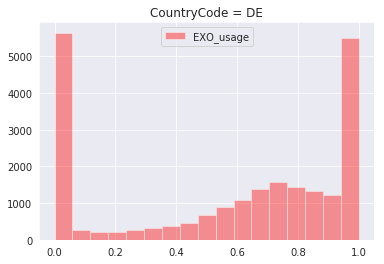

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
sns.distplot(np.array(df_young_tryC), color="red", label='EXO_usage',# norm_hist=True,
            kde=False)
plt.legend()
plt.title('CountryCode = DE')
# plt.title('Industry = Health Provider')
# plt.savefig('/home/t-chepan/projects/MS-intern-project/plots//{}_mature_vs_young_usage_hist.png'.format(wl_names[i]))
plt.show() 

In [97]:
sns.set_style('darkgrid')
sns.distplot(np.array(df_young_gb), color="red", label='EXO',# norm_hist=True,
            kde=False)

NameError: name 'df_young_gb' is not defined

In [68]:
TenantId_invalid_agentpick = ['1B72A3E4-A4B6-4BF3-BC99-3A4FCCFD821E',
'E386F5BF-C369-4018-90DF-DF41B3EA40C5',
'89C43F2F-A5D8-4715-9395-20F1C76331BF',
'3B09287B-093C-44CB-B641-7941B9286976',
'5BCCB627-7ED4-497B-86B3-29A0C4AAD4F9',
'728BC54B-C8F9-4CC4-84A6-B9D5772B346D',
'D51CEE6A-2CCE-4C0D-97CF-3F6358BAA921',
'F1DD20A6-C3A1-4FD0-BBED-F95C8E62AF80',
'1056EED8-603B-4B87-B769-BE13E5E3AE60',
'76E55386-3649-4709-9C40-C2D5289DFA2B',
'80988CD8-D7DD-438C-936B-29F2D0F5E21B',
'7413EFFA-FCEA-4C7B-A84C-794F6C40EBDF',
'D4CFB452-DB15-4210-86C9-6814CC269DF2',
'53F88218-62F9-4293-B973-D635F0A86173',
'26EE9674-753C-42A4-9F01-331FA06B142C']


In [69]:
df_young.loc[df_young.TenantId.isin(TenantId_invalid_agentpick), ['TenantId', 'PaidOD4BSeats', 'PaidOfficeSeats']]

,TenantId,PaidOD4BSeats,PaidOfficeSeats
36524,89C43F2F-A5D8-4715-9395-20F1C76331BF,17,0.0
59819,26EE9674-753C-42A4-9F01-331FA06B142C,195,0.0
77032,D51CEE6A-2CCE-4C0D-97CF-3F6358BAA921,2,0.0
100593,5BCCB627-7ED4-497B-86B3-29A0C4AAD4F9,2,0.0
117900,1B72A3E4-A4B6-4BF3-BC99-3A4FCCFD821E,0,0.0
140026,7413EFFA-FCEA-4C7B-A84C-794F6C40EBDF,21,0.0
181071,1056EED8-603B-4B87-B769-BE13E5E3AE60,5,0.0
185534,728BC54B-C8F9-4CC4-84A6-B9D5772B346D,0,0.0
250915,3B09287B-093C-44CB-B641-7941B9286976,1,0.0
254252,F1DD20A6-C3A1-4FD0-BBED-F95C8E62AF80,17,0.0


In [34]:
df_young.shape

(478934, 227)

In [35]:
with open('raw_data/configure.json', 'r') as f:
    metadata = json.load(f)

In [36]:
dv = joblib.load('encoded_data_clip_fast/cat_vectorizer.pkl')
scaler = joblib.load('encoded_data_clip_fast/scaler.pkl')

In [37]:
# yyoung, Xyoung, _, _, _, _ = encoding_data.encode_dataset(df_young, metadata, dv=dv, scaler=scaler)


In [38]:
# y_path = 'encoded_data_clip_fast/yyoung.npy'
# np.save(y_path, yyoung)
# X_path = 'encoded_data_clip_fast/Xyoung.npy'
# np.save(X_path, Xyoung)

In [39]:
Xyoung = np.load('encoded_data_clip_fast/Xyoung.npy')
yyoung = np.load('encoded_data_clip_fast/yyoung.npy')

In [40]:
outputs_name = [
     'AR_exchange_06',
 'AR_sharepoint_06',
 'AR_skype_06',
 'AR_teams_06',
 'AR_od4b_06',
 'AR_onenote_06',
 'AR_word_06',
 'AR_excel_06',
 'AR_powerpoint_06',
 'AR_outlook_06',
 'AR_eslt_06',
 'AR_officeclient_06'
]

In [41]:
display_cols = ['TenantId', 'CountryCode', 'TopParents_Industry','AllupSeats', 
                'PaidCount','PaidEXOSeats', 'PaidSPOSeats', 'PaidOD4BSeats',
                'PaidTeamsSeats', 'PaidSFBSeats', 'PaidOfficeSeats'
               ] + outputs_name

In [42]:
df_display = df_young.loc[:, display_cols]

In [43]:
df_display.head()

,TenantId,CountryCode,TopParents_Industry,AllupSeats,PaidCount,PaidEXOSeats,PaidSPOSeats,PaidOD4BSeats,PaidTeamsSeats,PaidSFBSeats,PaidOfficeSeats,AR_exchange_06,AR_sharepoint_06,AR_skype_06,AR_teams_06,AR_od4b_06,AR_onenote_06,AR_word_06,AR_excel_06,AR_powerpoint_06,AR_outlook_06,AR_eslt_06,AR_officeclient_06
0,BA7B5BCE-D586-42C6-BE1A-84E9AB627949,US,Health Provider,4,4,3,1,1,1,1,0.0,0.200000,0.000000,0.000000,0.0,0.70,0.0,0.050000,0.050000,0.000000,0.112500,0.325000,0.137500
1,4A4E174E-4783-4F13-84F9-C56DBBE9A00E,DE,0,12,12,12,1,1,1,1,0.0,0.641667,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.004167,0.641667,0.004167
2,1D58D097-C7EF-4734-8813-0DC9CA7D02F1,NZ,Other - Unsegmented,12,12,12,12,12,12,12,0.0,0.695833,0.004167,0.004167,0.0,0.10,0.0,0.083333,0.070833,0.029167,0.454167,0.708333,0.458333
3,8AEA6862-5D28-4FA1-A099-861B3D2A42F5,GB,Partner Professional Services,4,4,4,4,4,4,4,0.0,0.837500,0.000000,0.000000,0.0,0.00,0.0,0.012500,0.037500,0.000000,0.550000,0.837500,0.550000
4,D51B264C-FFC1-4DB2-ACDB-91313901DFB2,US,Smart Spaces,10,10,10,10,10,10,10,0.0,0.000000,1.000000,0.000000,0.0,0.05,0.0,0.085000,0.165000,0.025000,0.085000,1.000000,0.235000


In [44]:
df_display.shape

(478934, 23)

In [45]:
# load json and create model
model_n = 31
model_path = 'results_clip_fast/NNmodel_{}_with_1.0data.json'.format(model_n)
print(model_path)
weights_path = 'results_clip_fast/NNmodel_{}_with_1.0data_weights.hdf5'.format(model_n)

json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model 
loaded_model.compile(loss='mean_squared_error', optimizer='adam',
                     metrics=['mean_squared_error'])

W0910 21:52:37.398235 140583807227648 deprecation.py:506] From /data/home/t-chepan/env/newlab/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0910 21:52:37.399203 140583807227648 deprecation.py:506] From /data/home/t-chepan/env/newlab/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0910 21:52:37.400389 140583807227648 deprecation.py:506] From /data/home/t-chepan/env/newlab/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ze

results_clip_fast/NNmodel_31_with_1.0data.json
Loaded model from disk


In [46]:
young_pred = loaded_model.predict(Xyoung)

In [47]:
for i in range(len(young_pred[1])):
    col_name = outputs_name[i] +'_delta'
    df_display[col_name] = young_pred[:,i] - yyoung[:,i]

## use some criteria to filter the df_display

1. filter out the tenants without "TopParent_Industry" info
2. "PaidTeamsSeats" should equal to "PaidSFBSeats". filter out the tenant if these two don't match

In [48]:
df_display = df_display.loc[(df_display['TopParents_Industry'] != '0') &
                            (df_display['PaidSFBSeats'] == df_display['PaidTeamsSeats'])]

In [49]:
df_display.shape

(218943, 35)

In [50]:
df_display.head()

,TenantId,CountryCode,TopParents_Industry,AllupSeats,PaidCount,PaidEXOSeats,PaidSPOSeats,PaidOD4BSeats,PaidTeamsSeats,PaidSFBSeats,PaidOfficeSeats,AR_exchange_06,AR_sharepoint_06,AR_skype_06,AR_teams_06,AR_od4b_06,AR_onenote_06,AR_word_06,AR_excel_06,AR_powerpoint_06,AR_outlook_06,AR_eslt_06,AR_officeclient_06,AR_exchange_06_delta,AR_sharepoint_06_delta,AR_skype_06_delta,AR_teams_06_delta,AR_od4b_06_delta,AR_onenote_06_delta,AR_word_06_delta,AR_excel_06_delta,AR_powerpoint_06_delta,AR_outlook_06_delta,AR_eslt_06_delta,AR_officeclient_06_delta
0,BA7B5BCE-D586-42C6-BE1A-84E9AB627949,US,Health Provider,4,4,3,1,1,1,1,0.0,0.200000,0.000000,0.000000,0.0,0.700000,0.0,0.050000,0.050000,0.000000,0.112500,0.325000,0.137500,0.543858,0.117694,0.019130,0.062404,-0.427594,0.025144,0.079654,0.075237,0.025396,0.198359,0.203176,0.219655
2,1D58D097-C7EF-4734-8813-0DC9CA7D02F1,NZ,Other - Unsegmented,12,12,12,12,12,12,12,0.0,0.695833,0.004167,0.004167,0.0,0.100000,0.0,0.083333,0.070833,0.029167,0.454167,0.708333,0.458333,0.125491,0.106882,0.005339,0.039203,0.021141,0.007955,0.084364,0.093329,-0.011597,-0.026289,0.127774,-0.003867
3,8AEA6862-5D28-4FA1-A099-861B3D2A42F5,GB,Partner Professional Services,4,4,4,4,4,4,4,0.0,0.837500,0.000000,0.000000,0.0,0.000000,0.0,0.012500,0.037500,0.000000,0.550000,0.837500,0.550000,-0.059162,0.008565,-0.000694,0.002866,0.041110,0.001162,0.022745,-0.006215,0.000778,-0.342308,-0.051926,-0.332954
4,D51B264C-FFC1-4DB2-ACDB-91313901DFB2,US,Smart Spaces,10,10,10,10,10,10,10,0.0,0.000000,1.000000,0.000000,0.0,0.050000,0.0,0.085000,0.165000,0.025000,0.085000,1.000000,0.235000,0.448711,-0.866974,0.006135,0.036286,0.044273,0.006129,-0.012619,-0.093495,-0.016621,0.138160,-0.517456,0.022296
8,1CF88673-DC8E-4B75-88B0-F8BAF8CAA1E1,US,Nonprofit,13,13,13,13,13,13,13,0.0,0.784615,0.000000,0.000000,0.0,0.007692,0.0,0.030769,0.000000,0.000000,0.511538,0.788462,0.515385,-0.099972,0.001226,0.000492,0.001825,0.010294,0.001289,0.008700,0.037974,0.002771,-0.264243,-0.099477,-0.256491


## Mark each workload as 1/0/-1 (Hackathon)

In [51]:
delta_cols = df_display.columns[-12:]

paidseats = ['PaidEXOSeats', 'PaidSPOSeats', 'PaidSFBSeats','PaidTeamsSeats',
             'PaidOD4BSeats', 'PaidOfficeSeats', 'PaidOfficeSeats','PaidOfficeSeats',
             'PaidOfficeSeats','PaidOfficeSeats','PaidCount', 'PaidOfficeSeats']

targets = list(zip(paidseats, delta_cols, outputs_name))

In [52]:
threshold = 0.05

for ps, delta, acr in targets:
    def f(row):
        if row[ps] <= 0:
            val = -1
        else:
            if row[delta] > threshold and row[acr] < 1:
                val = 1
            else:
                val = 0
        return val
    
    vals = []
    for i, row in df_display.iterrows():
        vals.append(f(row))
        
    df_display['Rec_{}'.format(acr)] = vals


In [53]:
df_display.head(20)

,TenantId,CountryCode,TopParents_Industry,AllupSeats,PaidCount,PaidEXOSeats,PaidSPOSeats,PaidOD4BSeats,PaidTeamsSeats,PaidSFBSeats,PaidOfficeSeats,AR_exchange_06,AR_sharepoint_06,AR_skype_06,AR_teams_06,AR_od4b_06,AR_onenote_06,AR_word_06,AR_excel_06,AR_powerpoint_06,AR_outlook_06,AR_eslt_06,AR_officeclient_06,AR_exchange_06_delta,AR_sharepoint_06_delta,AR_skype_06_delta,AR_teams_06_delta,AR_od4b_06_delta,AR_onenote_06_delta,AR_word_06_delta,AR_excel_06_delta,AR_powerpoint_06_delta,AR_outlook_06_delta,AR_eslt_06_delta,AR_officeclient_06_delta,Rec_AR_exchange_06,Rec_AR_sharepoint_06,Rec_AR_skype_06,Rec_AR_teams_06,Rec_AR_od4b_06,Rec_AR_onenote_06,Rec_AR_word_06,Rec_AR_excel_06,Rec_AR_powerpoint_06,Rec_AR_outlook_06,Rec_AR_eslt_06,Rec_AR_officeclient_06
0,BA7B5BCE-D586-42C6-BE1A-84E9AB627949,US,Health Provider,4,4,3,1,1,1,1,0.0,0.200000,0.000000,0.000000,0.000000,0.700000,0.000000,0.050000,0.050000,0.000000,0.112500,0.325000,0.137500,0.543858,0.117694,0.019130,0.062404,-0.427594,0.025144,0.079654,0.075237,0.025396,0.198359,0.203176,0.219655,1,1,0,1,0,-1,-1,-1,-1,-1,1,-1
2,1D58D097-C7EF-4734-8813-0DC9CA7D02F1,NZ,Other - Unsegmented,12,12,12,12,12,12,12,0.0,0.695833,0.004167,0.004167,0.000000,0.100000,0.000000,0.083333,0.070833,0.029167,0.454167,0.708333,0.458333,0.125491,0.106882,0.005339,0.039203,0.021141,0.007955,0.084364,0.093329,-0.011597,-0.026289,0.127774,-0.003867,1,1,0,0,0,-1,-1,-1,-1,-1,1,-1
3,8AEA6862-5D28-4FA1-A099-861B3D2A42F5,GB,Partner Professional Services,4,4,4,4,4,4,4,0.0,0.837500,0.000000,0.000000,0.000000,0.000000,0.000000,0.012500,0.037500,0.000000,0.550000,0.837500,0.550000,-0.059162,0.008565,-0.000694,0.002866,0.041110,0.001162,0.022745,-0.006215,0.000778,-0.342308,-0.051926,-0.332954,0,0,0,0,0,-1,-1,-1,-1,-1,0,-1
4,D51B264C-FFC1-4DB2-ACDB-91313901DFB2,US,Smart Spaces,10,10,10,10,10,10,10,0.0,0.000000,1.000000,0.000000,0.000000,0.050000,0.000000,0.085000,0.165000,0.025000,0.085000,1.000000,0.235000,0.448711,-0.866974,0.006135,0.036286,0.044273,0.006129,-0.012619,-0.093495,-0.016621,0.138160,-0.517456,0.022296,1,0,0,0,0,-1,-1,-1,-1,-1,0,-1
8,1CF88673-DC8E-4B75-88B0-F8BAF8CAA1E1,US,Nonprofit,13,13,13,13,13,13,13,0.0,0.784615,0.000000,0.000000,0.000000,0.007692,0.000000,0.030769,0.000000,0.000000,0.511538,0.788462,0.515385,-0.099972,0.001226,0.000492,0.001825,0.010294,0.001289,0.008700,0.037974,0.002771,-0.264243,-0.099477,-0.256491,0,0,0,0,0,-1,-1,-1,-1,-1,0,-1
12,9CD246A5-CCB4-4ABC-8A73-4F0F61105855,US,Partner Professional Services,43,43,43,43,43,43,43,0.0,1.000000,0.000000,0.000000,0.005814,0.020930,0.000000,0.029070,0.070930,0.000000,0.166279,1.000000,0.187209,-0.261154,0.009949,0.008377,0.011325,0.007216,0.003212,0.078128,0.050430,0.015145,0.175086,-0.261905,0.173975,0,0,0,0,0,-1,-1,-1,-1,-1,0,-1
13,14D4740D-91C3-41F1-852E-C9A25D061BA2,IN,Other - Unsegmented,13,13,12,12,13,12,12,0.0,0.000000,0.000000,0.000000,0.025000,0.034615,0.003846,0.284615,0.346154,0.076923,0.426923,0.034615,0.438462,0.534782,0.025696,0.007690,0.001953,0.014061,0.004075,0.010943,-0.009329,-0.015561,0.020699,0.505213,0.101141,1,0,0,0,0,-1,-1,-1,-1,-1,1,-1
14,699570A1-3A63-4ABE-85BE-03B0E1898EAD,CH,Chemicals & Agrochemicals,20,20,15,15,20,15,15,0.0,0.790000,0.040000,0.000000,0.000000,0.072500,0.020000,0.000000,0.000000,0.002500,0.012500,0.592500,0.032500,-0.058395,0.154844,0.063217,0.158580,0.042965,0.008295,0.217243,0.272020,0.059675,0.431630,0.071603,0.460106,0,1,1,1,0,-1,-1,-1,-1,-1,1,-1
16,B6CA5863-FEAF-4146-B48C-84ED21F51461,US,Professional Services,5,5,0,0,3,0,0,0.0,0.000000,0.310000,0.000000,1.000000,0.083333,0.000000,0.210000,0.040000,0.000000,0.000000,1.000000,0.220000,0.012228,-0.282160,0.001182,-0.987980,-0.070786,0.008699,0.207373,0.328290,0.147838,0.189376,-0.966315,0.356968,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,0,-1
17,A77FC317-B47E-4C40-96AC-1E48854814E1,PL,Smart Spaces,6,5,5,0,0,0,0,0.0,0.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.370000,0.540000,0.390000,0.395577,0.042038,-0.001065,0.009044,

In [54]:
df_display.to_csv('results_clip_fast/rec_display_youngTenants_Hackathon_0.05threshold.csv', index=None)

In [55]:
# Kai said right now the policy is "if skype and teams should have the same PaidSeats" double check that

unvalid_tenant_1 = df_display.loc[(df_display['Rec_AR_skype_06'] == -1) & (df_display['Rec_AR_teams_06'] != -1), 
                                 'TenantId']
unvalid_tenant_2 = df_display.loc[(df_display['Rec_AR_skype_06'] != -1) & (df_display['Rec_AR_teams_06'] == -1), 
                                 'TenantId']

In [56]:
unvalid_tenant_1.shape

(0,)

In [57]:
unvalid_tenant_2.shape

(0,)

## Display the rank of AR_delta and the valid choice for agent

In [221]:
mask_paidseats = np.zeros((df_display.shape[0],12))
for i, ps in enumerate(paidseats):
    mask_paidseats[:,i] = np.where(df_display[ps]>0, 1, 0 )
    

In [21]:
np.sum(mask_paidseats)

1202246.0

In [22]:
mask_paidseats.shape

(218943, 12)

In [23]:
delta_cols

Index(['AR_exchange_06_delta', 'AR_sharepoint_06_delta', 'AR_skype_06_delta',
       'AR_teams_06_delta', 'AR_od4b_06_delta', 'AR_onenote_06_delta',
       'AR_word_06_delta', 'AR_excel_06_delta', 'AR_powerpoint_06_delta',
       'AR_outlook_06_delta', 'AR_eslt_06_delta', 'AR_officeclient_06_delta'],
      dtype='object')

In [24]:
df_delta = df_display.loc[:, delta_cols]

In [25]:
np.any(df_delta.values == 0.0)

False

In [26]:
df_delta.head()

,AR_exchange_06_delta,AR_sharepoint_06_delta,AR_skype_06_delta,AR_teams_06_delta,AR_od4b_06_delta,AR_onenote_06_delta,AR_word_06_delta,AR_excel_06_delta,AR_powerpoint_06_delta,AR_outlook_06_delta,AR_eslt_06_delta,AR_officeclient_06_delta
0,0.622803,0.180590,0.022984,0.081432,-0.358417,0.042938,0.107461,0.095227,0.015872,0.292096,0.351429,0.305690
2,0.105188,0.180440,0.009758,0.062738,0.057007,0.007490,0.086881,0.107100,-0.008685,0.007030,0.118159,0.031327
3,-0.077769,0.014180,0.001067,0.006423,0.040759,0.002410,0.019377,-0.009358,0.007219,-0.355217,-0.076431,-0.344759
4,0.320462,-0.926867,-0.001047,0.019184,-0.015469,-0.000652,-0.079392,-0.137518,-0.026782,0.025595,-0.605538,-0.087012
8,-0.114923,0.005883,-0.002634,0.003919,-0.003062,0.000109,0.041948,0.068970,0.006022,-0.223337,-0.117080,-0.216485


In [27]:
df_delta = df_delta * mask_paidseats

In [28]:
r_dict = dict(df_delta.iloc[0,:])
sorted_r = sorted(r_dict.items(), key=lambda kv: kv[1], reverse=True)
sorted_r

[('AR_exchange_06_delta', 0.6228033781051636),
 ('AR_eslt_06_delta', 0.35142927169799804),
 ('AR_sharepoint_06_delta', 0.1805901974439621),
 ('AR_teams_06_delta', 0.08143194019794464),
 ('AR_skype_06_delta', 0.022984003648161888),
 ('AR_excel_06_delta', 0.0),
 ('AR_powerpoint_06_delta', 0.0),
 ('AR_word_06_delta', 0.0),
 ('AR_outlook_06_delta', 0.0),
 ('AR_officeclient_06_delta', 0.0),
 ('AR_onenote_06_delta', 0.0),
 ('AR_od4b_06_delta', -0.35841695666313167)]

In [29]:
r_dict = dict(df_delta.iloc[0,:])
valid_wl = []
new_r_dict = {}

for k, v in r_dict.items():
    k = k[3:-9]
    if v != 0.0:
        valid_wl.append(k)
    if v > 0.0:
        new_r_dict[k] = v

new_r_dict = collections.OrderedDict(sorted(new_r_dict.items(), key=lambda kv: kv[1], reverse=True))
        
print(list(new_r_dict.keys()))
        
print(valid_wl)

['exchange', 'eslt', 'sharepoint', 'teams', 'skype']
['od4b', 'eslt', 'exchange', 'skype', 'sharepoint', 'teams']


In [30]:
# get the valid workload names and rand=k the recommended workloads
def f(row):
    r_dict = dict(row)
    valid_wl = []
    new_r_dict = {}

    for k, v in r_dict.items():
        k = k[3:-9]
        if v != 0.0:
            valid_wl.append(k)
        if v > 0.0:
            new_r_dict[k] = v

    new_r_dict = collections.OrderedDict(sorted(new_r_dict.items(), key=lambda kv: kv[1], reverse=True))
    
    return valid_wl, list(new_r_dict.keys())

In [31]:
valid_wl = []
rec = []
for i, row in df_delta.iterrows():
    wl, rank = f(row)
    valid_wl.append(wl)
    rec.append(rank)
    
df_delta['valid_choice'] = valid_wl
df_delta['rec'] = rec

In [32]:
df_delta.head()

,AR_exchange_06_delta,AR_sharepoint_06_delta,AR_skype_06_delta,AR_teams_06_delta,AR_od4b_06_delta,AR_onenote_06_delta,AR_word_06_delta,AR_excel_06_delta,AR_powerpoint_06_delta,AR_outlook_06_delta,AR_eslt_06_delta,AR_officeclient_06_delta,valid_choice,rec
0,0.622803,0.180590,0.022984,0.081432,-0.358417,0.0,0.0,0.0,0.0,0.0,0.351429,0.0,"[od4b, eslt, exchange, skype, sharepoint, teams]","[exchange, eslt, sharepoint, teams, skype]"
2,0.105188,0.180440,0.009758,0.062738,0.057007,0.0,0.0,0.0,-0.0,0.0,0.118159,0.0,"[od4b, eslt, exchange, skype, sharepoint, teams]","[sharepoint, eslt, exchange, teams, od4b, skype]"
3,-0.077769,0.014180,0.001067,0.006423,0.040759,0.0,0.0,-0.0,0.0,-0.0,-0.076431,-0.0,"[od4b, eslt, exchange, skype, sharepoint, teams]","[od4b, sharepoint, teams, skype]"
4,0.320462,-0.926867,-0.001047,0.019184,-0.015469,-0.0,-0.0,-0.0,-0.0,0.0,-0.605538,-0.0,"[od4b, eslt, exchange, skype, sharepoint, teams]","[exchange, teams]"
8,-0.114923,0.005883,-0.002634,0.003919,-0.003062,0.0,0.0,0.0,0.0,-0.0,-0.117080,-0.0,"[od4b, eslt, exchange, skype, sharepoint, teams]","[sharepoint, teams]"


In [33]:
df_delta.shape

(218943, 14)

In [34]:
df_display.shape

(218943, 35)

In [35]:
df_display.head()

,TenantId,CountryCode,TopParents_Industry,AllupSeats,PaidCount,PaidEXOSeats,PaidSPOSeats,PaidOD4BSeats,PaidTeamsSeats,PaidSFBSeats,PaidOfficeSeats,AR_exchange_06,AR_sharepoint_06,AR_skype_06,AR_teams_06,AR_od4b_06,AR_onenote_06,AR_word_06,AR_excel_06,AR_powerpoint_06,AR_outlook_06,AR_eslt_06,AR_officeclient_06,AR_exchange_06_delta,AR_sharepoint_06_delta,AR_skype_06_delta,AR_teams_06_delta,AR_od4b_06_delta,AR_onenote_06_delta,AR_word_06_delta,AR_excel_06_delta,AR_powerpoint_06_delta,AR_outlook_06_delta,AR_eslt_06_delta,AR_officeclient_06_delta
0,BA7B5BCE-D586-42C6-BE1A-84E9AB627949,US,Health Provider,4,4,3,1,1,1,1,0.0,0.200000,0.000000,0.000000,0.0,0.700000,0.0,0.050000,0.050000,0.000000,0.112500,0.325000,0.137500,0.622803,0.180590,0.022984,0.081432,-0.358417,0.042938,0.107461,0.095227,0.015872,0.292096,0.351429,0.305690
2,1D58D097-C7EF-4734-8813-0DC9CA7D02F1,NZ,Other - Unsegmented,12,12,12,12,12,12,12,0.0,0.695833,0.004167,0.004167,0.0,0.100000,0.0,0.083333,0.070833,0.029167,0.454167,0.708333,0.458333,0.105188,0.180440,0.009758,0.062738,0.057007,0.007490,0.086881,0.107100,-0.008685,0.007030,0.118159,0.031327
3,8AEA6862-5D28-4FA1-A099-861B3D2A42F5,GB,Partner Professional Services,4,4,4,4,4,4,4,0.0,0.837500,0.000000,0.000000,0.0,0.000000,0.0,0.012500,0.037500,0.000000,0.550000,0.837500,0.550000,-0.077769,0.014180,0.001067,0.006423,0.040759,0.002410,0.019377,-0.009358,0.007219,-0.355217,-0.076431,-0.344759
4,D51B264C-FFC1-4DB2-ACDB-91313901DFB2,US,Smart Spaces,10,10,10,10,10,10,10,0.0,0.000000,1.000000,0.000000,0.0,0.050000,0.0,0.085000,0.165000,0.025000,0.085000,1.000000,0.235000,0.320462,-0.926867,-0.001047,0.019184,-0.015469,-0.000652,-0.079392,-0.137518,-0.026782,0.025595,-0.605538,-0.087012
8,1CF88673-DC8E-4B75-88B0-F8BAF8CAA1E1,US,Nonprofit,13,13,13,13,13,13,13,0.0,0.784615,0.000000,0.000000,0.0,0.007692,0.0,0.030769,0.000000,0.000000,0.511538,0.788462,0.515385,-0.114923,0.005883,-0.002634,0.003919,-0.003062,0.000109,0.041948,0.068970,0.006022,-0.223337,-0.117080,-0.216485


In [36]:
df_display_full = pd.concat([df_display,
                             df_delta.iloc[:, -2:]], axis=1)

In [37]:
df_display_full.shape

(218943, 37)

In [38]:
# df_display_full.to_csv('results/rec_dispaly_full.csv', index=False)

In [39]:
show_cols = ['TenantId', 'CountryCode', 'TopParents_Industry','AllupSeats',
             'PaidCount'] + outputs_name + ['valid_choice', 'rec']

df_display_show = df_display_full.loc[:, show_cols]

In [40]:
np.any(df_display_show['rec'] == '[]')

False

In [41]:
# df_display_show = df_display_show.loc[(df_display_show.AR_exchange_06 <= 1.0) &
#                                       (df_display_show.AR_sharepoint_06 <= 1.0) &
#                                       (df_display_show.AR_skype_06 <= 1.0) &
#                                       (df_display_show.AR_teams_06 <= 1.0) &
#                                       (df_display_show.AR_od4b_06 <= 1.0) &
#                                       (df_display_show.AR_eslt_06 <= 1.0) & 
#                                       (df_display_show.AR_onenote_06 <= 1.0) &
#                                       (df_display_show.AR_word_06 <= 1.0) &
#                                       (df_display_show.AR_excel_06 <= 1.0) & 
#                                       (df_display_show.AR_powerpoint_06 <= 1.0) &
#                                       (df_display_show.AR_outlook_06 <= 1.0) &
#                                       (df_display_show.AR_officeclient_06 <= 1.0) &
#                                       (df_display_show.astype(str)['rec'] != '[]')]

In [42]:
df_display_show.shape

(218943, 19)

In [43]:
df_display_show.columns = ['TenantId', 'CountryCode', 'TopParents_Industry',
                           'AllupSeats','PaidCount', 'exchange_usage','sharepoint_usage',
                           'skype_usage','teams_usage','od4b_usage','onenote_usage',
                           'word_usage','excel_usage','powerpoint_usage','outlook_usage',
                           'eslt_usage','officeclient_usage', 'Valid_Choice','Recommender from Model']

In [44]:
df_display_show.head()

,TenantId,CountryCode,TopParents_Industry,AllupSeats,PaidCount,exchange_usage,sharepoint_usage,skype_usage,teams_usage,od4b_usage,onenote_usage,word_usage,excel_usage,powerpoint_usage,outlook_usage,eslt_usage,officeclient_usage,Valid_Choice,Recommender from Model
0,BA7B5BCE-D586-42C6-BE1A-84E9AB627949,US,Health Provider,4,4,0.200000,0.000000,0.000000,0.0,0.700000,0.0,0.050000,0.050000,0.000000,0.112500,0.325000,0.137500,"[od4b, eslt, exchange, skype, sharepoint, teams]","[exchange, eslt, sharepoint, teams, skype]"
2,1D58D097-C7EF-4734-8813-0DC9CA7D02F1,NZ,Other - Unsegmented,12,12,0.695833,0.004167,0.004167,0.0,0.100000,0.0,0.083333,0.070833,0.029167,0.454167,0.708333,0.458333,"[od4b, eslt, exchange, skype, sharepoint, teams]","[sharepoint, eslt, exchange, teams, od4b, skype]"
3,8AEA6862-5D28-4FA1-A099-861B3D2A42F5,GB,Partner Professional Services,4,4,0.837500,0.000000,0.000000,0.0,0.000000,0.0,0.012500,0.037500,0.000000,0.550000,0.837500,0.550000,"[od4b, eslt, exchange, skype, sharepoint, teams]","[od4b, sharepoint, teams, skype]"
4,D51B264C-FFC1-4DB2-ACDB-91313901DFB2,US,Smart Spaces,10,10,0.000000,1.000000,0.000000,0.0,0.050000,0.0,0.085000,0.165000,0.025000,0.085000,1.000000,0.235000,"[od4b, eslt, exchange, skype, sharepoint, teams]","[exchange, teams]"
8,1CF88673-DC8E-4B75-88B0-F8BAF8CAA1E1,US,Nonprofit,13,13,0.784615,0.000000,0.000000,0.0,0.007692,0.0,0.030769,0.000000,0.000000,0.511538,0.788462,0.515385,"[od4b, eslt, exchange, skype, sharepoint, teams]","[sharepoint, teams]"


In [103]:
df_display_show.to_csv('evaluation/rec_display_rank_valid_wl.csv', index=None)